<a href="https://colab.research.google.com/github/zenghx/ML-MC/blob/master/ML_MC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#将github中的repo clone过来运行，左侧文件里有就不需要运行

In [0]:
!git clone https://github.com/zenghx/ML-MC.git
import os
os.chdir("/content/ML-MC")


#开启TensorFlow Eager模式

In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tfe.enable_eager_execution()

#将文件转换为tfRecord
参照了[这个](https://www.cnblogs.com/wyh1993/p/6703135.html)和
[猫狗大战](https://www.cnblogs.com/ansang/p/9126427.html)

In [0]:
import os
import glob
import tensorflow as tf
import numpy as np
from skimage import io,color,transform

def _int64_feature(value):
    if not isinstance(value,list):
        value=[value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))
def _byte_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def to_tfrecord(data_path,dest_path):
  os.chdir(data_path)
  folders=os.listdir()
  folders.sort()
  i=0
  with tf.python_io.TFRecordWriter(dest_path) as writer:
    for folder in folders:
      path=data_path+"/"+folder
      img_paths=glob.glob(os.path.join(path,"*.jpg"))
      for img_path in img_paths:
        img=io.imread(img_path)
        #img=color.rgb2gray(img)
        img = transform.resize(img, [150, 150])
        if 3 == img.ndim:
          rows, cols, depth = img.shape
        else:
          rows, cols = img.shape
          depth = 1
        labels=[0]*6
        labels[i]=1
        example=tf.train.Example(features=tf.train.Features(feature={
            'width':_int64_feature(cols),
            'height':_int64_feature(rows),
            'depth':_int64_feature(depth),
            'image_raw':_byte_feature(img.astype(np.float32).tobytes()),
            'label':_int64_feature(labels)}))
        writer.write(example.SerializeToString())#把example加入到writer里，最后写到磁盘。
      i=i+1
  writer.close()
  print(dest_path+" has been written successfully!")
to_tfrecord("/content/ML-MC/seg_train","/content/ML-MC/train.record")     
to_tfrecord("/content/ML-MC/seg_test","/content/ML-MC/test.record") 

/content/ML-MC/train.record has been written successfully!
/content/ML-MC/test.record has been written successfully!


# Model

##GPU训练

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import tensorflow as tf
import numpy as np


batch_size=32
model_dir='/content/ML-MC/Model'
classes=6


MODES = [tf.estimator.ModeKeys.TRAIN, tf.estimator.ModeKeys.EVAL, tf.estimator.ModeKeys.PREDICT]


def input_fn(mode, batch_size=1):
    """输入函数"""

    def parser(serialized_example):
        """如何处理数据集中的每一个数据"""

        # 解析单个example对象
        features = tf.parse_single_example(
            serialized_example,
            features={
                'width':tf.FixedLenFeature([], tf.int64),
                'height':tf.FixedLenFeature([], tf.int64),
                'depth':tf.FixedLenFeature([], tf.int64),
                'image_raw':tf.FixedLenFeature([],tf.string),
                'label':tf.FixedLenFeature([6],tf.int64)
            })

        # 获取参数
        depth = tf.cast(features['depth'], tf.int64)
        height = tf.cast(features['height'], tf.int64)
        width = tf.cast(features['width'], tf.int64)

        # 还原image
        image = tf.decode_raw(features['image_raw'], tf.float32)
        image = tf.reshape(image, [height,width, depth])
        image = image - 0.5

        # 还原label
        label = tf.cast(features['label'], tf.int32)
        return image, label

    if mode==tf.estimator.ModeKeys.TRAIN:
        tfrecords_file = "/content/ML-MC/train.record"
    elif mode==tf.estimator.ModeKeys.EVAL:
        tfrecords_file = "/content/ML-MC/test.record"
    else:
        raise ValueError("Mode 未知")

    

    # 创建数据集
    dataset = tf.data.TFRecordDataset([tfrecords_file])
    # 创建映射
    dataset = dataset.map(parser, num_parallel_calls=2)
    # 设置batch
    dataset = dataset.shuffle(buffer_size= 14034).batch(batch_size).prefetch(1000)
    # 如果是训练，那么就永久循环下去
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.repeat()
    # 创建迭代器
    iterator = dataset.make_one_shot_iterator()
    # 获取 feature 和 label
    images, labels = iterator.get_next()

    return images, labels


def my_model(inputs, mode):
    """写一个网络"""
    net = tf.reshape(inputs, [-1, 150,150, 3])
    net = tf.layers.conv2d(net, 64, [3, 3], padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(net, [2, 2], strides=2)
    net = tf.layers.conv2d(net, 64, [3, 3], padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(net, [2, 2], strides=2)
    net = tf.layers.conv2d(net, 32, [3, 3], padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, 32, [3, 3], padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(net, [2, 2], strides=2)
    #print(net)
    net = tf.reshape(net, [-1, 18*18*32])
    net = tf.layers.dense(net, 1024, activation=tf.nn.relu)
    net = tf.layers.dropout(net, 0.4, training=(mode == tf.estimator.ModeKeys.TRAIN))    
    net = tf.layers.dense(net, classes)
    return net


def my_model_fn(features, labels, mode):
    """模型函数"""

    # 可视化输入
    #tf.summary.image('images', features)

    # 创建网络
    logits = my_model(features, mode)
    predictions = {
        'classes': tf.argmax(input=logits, axis=1),
        'probabilities': tf.nn.softmax(logits, name='softmax_tensor')
    }

    # 如果是PREDICT，那么只需要predictions就够了
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # 创建Loss
    loss = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=logits, scope='loss')
    tf.summary.scalar('train_loss', loss)

    # 设置如何训练
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
        train_op = optimizer.minimize(loss, tf.train.get_or_create_global_step())
    else:
        train_op = None

    # 获取训练精度
    accuracy = tf.metrics.accuracy(
        tf.argmax(labels, axis=1), predictions['classes'],
        name='accuracy')

    accuracy_topk = tf.metrics.mean(
        tf.nn.in_top_k(predictions['probabilities'], tf.argmax(labels, axis=1), 2),
        name='accuracy_topk')

    metrics = {
        'test_accuracy': accuracy,
        'test_accuracy_topk': accuracy_topk
    }

    # 可视化训练精度
    tf.summary.scalar('train_accuracy', accuracy[1])
    tf.summary.scalar('train_accuracy_topk', accuracy_topk[1])
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predictions,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=metrics,
    )


def main(_):


    # 创建 Estimator
    model = tf.estimator.Estimator(
        model_fn=my_model_fn,
        model_dir=model_dir)
    es_hook = tf.contrib.estimator.stop_if_no_decrease_hook(model, "loss", 3000)
    # 监视器
    logging_hook = tf.train.LoggingTensorHook(
        every_n_iter=100,
        tensors={
            'accuracy': 'accuracy/value',
            'accuracy_topk': 'accuracy_topk/value',
            'loss': 'loss/value'
        },
    )
    
    
    for i in range(5):
        # 训练

        model.train(
            input_fn=lambda: input_fn(tf.estimator.ModeKeys.TRAIN,batch_size),
            steps=439,
            hooks=[logging_hook])

        # 测试并输出结果
        print("=" * 10, "Testing", "=" * 10)
        eval_results = model.evaluate(
            input_fn=lambda: input_fn(tf.estimator.ModeKeys.EVAL),
           )
        print('Evaluation results:\n\t{}'.format(eval_results))
        print("=" * 30)


if __name__ == '__main__':
    #tf.logging.set_verbosity(tf.logging.INFO)
    tf.app.run()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/content/ML-MC/Model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbf9599ccc0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://gi

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


##TPU训练尝试，要求过于复杂死板，放弃

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import tensorflow as tf
import numpy as np

####Delete all flags before declare#####

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)

tf.flags.DEFINE_string(
    "tpu", default=None,
    help="The Cloud TPU to use for training. This should be the name used when "
    "creating the Cloud TPU. To find out hte name of TPU, either use command "
    "'gcloud compute tpus list --zone=<zone-name>', or use "
    "'ctpu status --details' if you have created Cloud TPU using 'ctpu up'.")

# Model specific parameters
tf.flags.DEFINE_string(
    "model_dir", default="'/content/ML-MC/Model'",
    help="This should be the path of GCS bucket which will be used as "
    "model_directory to export the checkpoints during training.")
tf.flags.DEFINE_integer(
    "batch_size", default=64,
    help="This is the global batch size and not the per-shard batch.")
tf.flags.DEFINE_integer(
    "train_steps", default=220,
    help="Total number of training steps.")
tf.flags.DEFINE_integer(
    "eval_steps", default=4,
    help="Total number of evaluation steps. If `0`, evaluation "
    "after training is skipped.")

# TPU specific parameters.
tf.flags.DEFINE_bool(
    "use_tpu", default=True,
    help="True, if want to run the model on TPU. False, otherwise.")
tf.flags.DEFINE_integer(
    "iterations", default=500,
    help="Number of iterations per TPU training loop.")

FLAGS = tf.flags.FLAGS

classes=6


MODES = [tf.estimator.ModeKeys.TRAIN, tf.estimator.ModeKeys.EVAL, tf.estimator.ModeKeys.PREDICT]


def input_fn(mode, batch_size=1):
    """输入函数"""

    def parser(serialized_example):
        """如何处理数据集中的每一个数据"""

        # 解析单个example对象
        features = tf.parse_single_example(
            serialized_example,
            features={
                'width':tf.FixedLenFeature([], tf.int64),
                'height':tf.FixedLenFeature([], tf.int64),
                'depth':tf.FixedLenFeature([], tf.int64),
                'image_raw':tf.FixedLenFeature([],tf.string),
                'label':tf.FixedLenFeature([6],tf.int64)
            })

        # 获取参数
        depth = tf.cast(features['depth'], tf.int64)
        height = tf.cast(features['height'], tf.int64)
        width = tf.cast(features['width'], tf.int64)

        # 还原image
        image = tf.decode_raw(features['image_raw'], tf.float32)
        image = tf.reshape(image, [height,width, depth])
        image = image - 0.5

        # 还原label
        label = tf.cast(features['label'], tf.int32)
        return image, label

    if mode==tf.estimator.ModeKeys.TRAIN:
        tfrecords_file = "/content/ML-MC/train.record"
    elif mode==tf.estimator.ModeKeys.EVAL:
        tfrecords_file = "/content/ML-MC/test.record"
    else:
        raise ValueError("Mode 未知")

    

    # 创建数据集
    dataset = tf.data.TFRecordDataset([tfrecords_file])
    # 创建映射
    dataset = dataset.map(parser, num_parallel_calls=2)
    # 设置batch
    dataset = dataset.shuffle(buffer_size= 14034).prefetch(1000)
    dataset = dataset.apply(tf.contrib.data.batch_and_drop_remainder(batch_size))
    # 如果是训练，那么就永久循环下去
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.repeat().apply(tf.contrib.data.batch_and_drop_remainder(batch_size))
    # 创建迭代器
    iterator = dataset.make_one_shot_iterator()
    # 获取 feature 和 label
    images, labels = iterator.get_next()

    return images, labels


def my_model(inputs, mode):
    """写一个网络"""
    net = tf.reshape(inputs, [-1, 150,150, 1])
    net = tf.layers.conv2d(net, 32, [5, 5], padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(net, [3, 3], strides=2)
    net = tf.layers.conv2d(net, 32, [5, 5], padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(net, [3, 3], strides=2)
    net = tf.layers.conv2d(net, 64, [5, 5], padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, 64, [5, 5], padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(net, [3, 3], strides=2)
    #print(net)
    net = tf.reshape(net, [-1, 17*17*64])
    net = tf.layers.dense(net, 1024, activation=tf.nn.relu)
    net = tf.layers.dropout(net, 0.4, training=(mode == tf.estimator.ModeKeys.TRAIN))    
    net = tf.layers.dense(net, classes)
    return net

def metric_fn(labels, logits):
  predictions = {
  'classes': tf.argmax(input=logits, axis=1),
  'probabilities': tf.nn.softmax(logits, name='softmax_tensor')
  }
  accuracy = tf.metrics.accuracy(
  tf.argmax(labels, axis=1), predictions['classes'],
  name='accuracy')
  accuracy_topk = tf.metrics.mean(
  tf.nn.in_top_k(predictions['probabilities'], tf.argmax(labels, axis=1), 2),
  name='accuracy_topk')
  return { 'test_accuracy': accuracy, 'test_accuracy_topk': accuracy_topk}

def my_model_fn(features,labels,mode,params):
    """模型函数"""
    
    # 可视化输入
    tf.summary.image('images', features)

    # 创建网络
    logits = my_model(features, mode)
    predictions = {
        'classes': tf.argmax(input=logits, axis=1),
        'probabilities': tf.nn.softmax(logits, name='softmax_tensor')
    }

    # 如果是PREDICT，那么只需要predictions就够了
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, predictions=predictions)

    # 创建Loss
    loss = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=logits, scope='loss')
    tf.summary.scalar('train_loss', loss)

    # 设置如何训练



  # Create training op.
    if mode == tf.estimator.ModeKeys.TRAIN:
      optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
      if FLAGS.use_tpu:
        optimizer = tf.contrib.tpu.AdamOptimizer(optimizer)
      train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
      return tf.contrib.tpu.TPUEstimatorSpec(mode, loss=loss, train_op=train_op)
        
    # 获取训练精度
    accuracy = tf.metrics.accuracy(
        tf.argmax(labels, axis=1), predictions['classes'],
        name='accuracy')

    accuracy_topk = tf.metrics.mean(
        tf.nn.in_top_k(predictions['probabilities'], tf.argmax(labels, axis=1), 2),
        name='accuracy_topk')

    metrics = {
        'test_accuracy': accuracy,
        'test_accuracy_topk': accuracy_topk
    }

    # 可视化训练精度
    tf.summary.scalar('train_accuracy', accuracy[1])
    tf.summary.scalar('train_accuracy_topk', accuracy_topk[1])

    return tf.contrib.tpu.TPUEstimatorSpec(
        mode=mode, loss=loss,predictions=predictions, eval_metrics=(metric_fn, [labels, predictions]))

def main(_):
    tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(
      FLAGS.tpu)

    run_config = tf.contrib.tpu.RunConfig(
      model_dir=FLAGS.model_dir,
      cluster=tpu_cluster_resolver,
      session_config=tf.ConfigProto(
          allow_soft_placement=True, log_device_placement=True),
      tpu_config=tf.contrib.tpu.TPUConfig(FLAGS.iterations),
  )
    # 监视器
    logging_hook = tf.train.LoggingTensorHook(
        every_n_iter=100,
        tensors={
            'accuracy': 'accuracy/value',
            'accuracy_topk': 'accuracy_topk/value',
            'loss': 'loss/value'
        },
    )

    # 创建 Estimator
    model = tf.contrib.tpu.TPUEstimator(
      model_fn=my_model_fn,
      use_tpu=FLAGS.use_tpu,
      train_batch_size=FLAGS.batch_size,
      eval_batch_size=FLAGS.batch_size,
      predict_batch_size=FLAGS.batch_size,
      config=run_config)

    
    
    for i in range(5):
        # 训练
        model.train(
            input_fn=lambda params: input_fn(tf.estimator.ModeKeys.TRAIN, params["batch_size"]),
            steps=FLAGS.train_steps
            )

        # 测试并输出结果
        print("=" * 10, "Testing", "=" * 10)
        eval_results = model.evaluate(
            input_fn=lambda params: input_fn(tf.estimator.ModeKeys.EVAL, params["batch_size"]),
            steps=FLAGS.eval_steps)
        print('Evaluation results:\n\t{}'.format(eval_results))
        print("=" * 30)


if __name__ == '__main__':
    #tf.logging.set_verbosity(tf.logging.INFO)
    tf.app.run()


##清除保存的模型

In [0]:
import os
os.chdir("/content/ML-MC")
!pwd
!rm -rf Model
!pwd

/content/ML-MC
/content/ML-MC


#预测

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os
import sys
import tensorflow as tf
from skimage import io, transform, color, util

mode = tf.estimator.ModeKeys.PREDICT
image_size = [150,150]
label=[0]*6
image_files = '/content/ML-MC/3.jpg'
model_dir = '/content/ML-MC'
batch_size=32
classes=6

def input_fn(mode, batch_size=1):
    """输入函数"""

    def parser(serialized_example):
        """如何处理数据集中的每一个数据"""

        # 解析单个example对象
        features = tf.parse_single_example(
            serialized_example,
            features={
                'width':tf.FixedLenFeature([], tf.int64),
                'height':tf.FixedLenFeature([], tf.int64),
                'depth':tf.FixedLenFeature([], tf.int64),
                'image_raw':tf.FixedLenFeature([],tf.string),
                'label':tf.FixedLenFeature([6],tf.int64)
            })

        # 获取参数
        depth = tf.cast(features['depth'], tf.int64)
        height = tf.cast(features['height'], tf.int64)
        width = tf.cast(features['width'], tf.int64)

        # 还原image
        image = tf.decode_raw(features['image_raw'], tf.float32)
        image = tf.reshape(image, [height,width, depth])
        image = image - 0.5

        # 还原label
        label = tf.cast(features['label'], tf.int32)
        return image, label

    if mode==tf.estimator.ModeKeys.TRAIN:
        tfrecords_file = "/content/ML-MC/train.record"
    elif mode==tf.estimator.ModeKeys.EVAL:
        tfrecords_file = "/content/ML-MC/test.record"
    else:
        raise ValueError("Mode 未知")

    

    # 创建数据集
    dataset = tf.data.TFRecordDataset([tfrecords_file])
    # 创建映射
    dataset = dataset.map(parser, num_parallel_calls=2)
    # 设置batch
    dataset = dataset.shuffle(buffer_size= 14034).batch(batch_size).prefetch(1000)
    # 如果是训练，那么就永久循环下去
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.repeat()
    # 创建迭代器
    iterator = dataset.make_one_shot_iterator()
    # 获取 feature 和 label
    images, labels = iterator.get_next()

    return images, labels


def my_model(inputs, mode):
    """写一个网络"""
    net = tf.reshape(inputs, [-1, 150,150, 3])
    net = tf.layers.conv2d(net, 64, [3, 3], padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(net, [2, 2], strides=2)
    net = tf.layers.conv2d(net, 64, [3, 3], padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(net, [2, 2], strides=2)
    net = tf.layers.conv2d(net, 32, [3, 3], padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, 32, [3, 3], padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(net, [2, 2], strides=2)
    #print(net)
    net = tf.reshape(net, [-1, 18*18*32])
    net = tf.layers.dense(net, 1024, activation=tf.nn.relu)
    net = tf.layers.dropout(net, 0.4, training=(mode == tf.estimator.ModeKeys.TRAIN))    
    net = tf.layers.dense(net, classes)
    return net
  
def my_model_fn(features, labels, mode):
    """模型函数"""

    # 可视化输入
    #tf.summary.image('images', features)

    # 创建网络
    logits = my_model(features, mode)
    predictions = {
        'classes': tf.argmax(input=logits, axis=1),
        'probabilities': tf.nn.softmax(logits, name='softmax_tensor')
    }

    # 如果是PREDICT，那么只需要predictions就够了
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # 创建Loss
    loss = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=logits, scope='loss')
    tf.summary.scalar('train_loss', loss)

    # 设置如何训练
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
        train_op = optimizer.minimize(loss, tf.train.get_or_create_global_step())
    else:
        train_op = None

    # 获取训练精度
    accuracy = tf.metrics.accuracy(
        tf.argmax(labels, axis=1), predictions['classes'],
        name='accuracy')

    accuracy_topk = tf.metrics.mean(
        tf.nn.in_top_k(predictions['probabilities'], tf.argmax(labels, axis=1), 2),
        name='accuracy_topk')

    metrics = {
        'test_accuracy': accuracy,
        'test_accuracy_topk': accuracy_topk
    }

    # 可视化训练精度
    tf.summary.scalar('train_accuracy', accuracy[1])
    tf.summary.scalar('train_accuracy_topk', accuracy_topk[1])
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predictions,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=metrics,
    )


def main(unused_argv):
  # Using the Winograd non-fused algorithms provides a small performance boost.
  os.environ['TF_ENABLE_WINOGRAD_NONFUSED'] = '1'
  #
  model = tf.estimator.Estimator(
      model_fn=my_model_fn,
      model_dir=model_dir)
  def predict_input_fn(image_path):
      img = io.imread(image_path)
      #img = color.rgb2gray(img)
      img = transform.resize(img, [150, 150])
      image = tf.image.convert_image_dtype(img, dtype=tf.float32)
      images = image - 0.5
      # preprocess image: scale pixel values from 0-255 to 0-1
      
      dataset = tf.data.Dataset.from_tensors((images,))
      return dataset.batch(1).make_one_shot_iterator().get_next(),label

  def predict(image_path):
      classes=["Buildings","Forest","Glacier","Mountain","Sea","Street"]
      result = model.predict(input_fn=lambda: predict_input_fn(image_path=image_path))
      for r in result:
          print(r)
          print(classes[r['classes']],"---------->Possibility:",r['probabilities'][r['classes']])
  predict(image_files)



if __name__ == '__main__':
  tf.logging.set_verbosity(tf.logging.INFO)
  tf.app.run(main=main)

In [0]:
!wget "https://media-cdn.tripadvisor.com/media/photo-s/11/83/a0/64/underwater-with-australian.jpg" -O "3.jpg"

# 测试用

##随机性测试

[[1 0 0 0 0 0]]


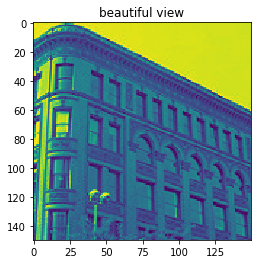

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np
def input_fn(mode, batch_size=1):
    """输入函数"""

    def parser(serialized_example):
        """如何处理数据集中的每一个数据"""

        # 解析单个example对象
        features = tf.parse_single_example(
            serialized_example,
            features={
                'width':tf.FixedLenFeature([], tf.int64),
                'height':tf.FixedLenFeature([], tf.int64),
                'depth':tf.FixedLenFeature([], tf.int64),
                'image_raw':tf.FixedLenFeature([],tf.string),
                'label':tf.FixedLenFeature([6],tf.int64)
            })

        # 获取参数
        depth = tf.cast(features['depth'], tf.int64)
        height = tf.cast(features['height'], tf.int64)
        width = tf.cast(features['width'], tf.int64)

        # 还原image
        image = tf.decode_raw(features['image_raw'], tf.float32)
        image = tf.reshape(image, [height,width, depth])
        image = image - 0.5

        # 还原label
        label = tf.cast(features['label'], tf.int32)
        return image, label

    if mode==tf.estimator.ModeKeys.TRAIN:
        tfrecords_file = "/content/ML-MC/train.record"
    elif mode==tf.estimator.ModeKeys.EVAL:
        tfrecords_file = "/content/ML-MC/test.record"
    else:
        raise ValueError("Mode 未知")

    

    # 创建数据集
    dataset = tf.data.TFRecordDataset([tfrecords_file])
    # 创建映射
    dataset = dataset.map(parser, num_parallel_calls=2)
    # 设置batch
    dataset = dataset.shuffle(buffer_size= 14034).batch(batch_size).prefetch(1000)
    # 如果是训练，那么就永久循环下去
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.repeat()
    # 创建迭代器
    iterator = dataset.make_one_shot_iterator()
    # 获取 feature 和 label
    images, labels = iterator.get_next()

    return images, labels
images,label=input_fn(tf.estimator.ModeKeys.TRAIN)
sess = tf.Session()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)
images,label= sess.run([images,label])
# 关闭线程以及会话
coord.request_stop()
coord.join(threads)
sess.close()

# 显示读取到的图片
print(label)
plt.imshow(np.squeeze(images),cmap="gray")

plt.title("beautiful view")
plt.show()

##tfRecord还原图片测试

Tensor("ParseSingleExample_2/ParseSingleExample:1", shape=(), dtype=int64)


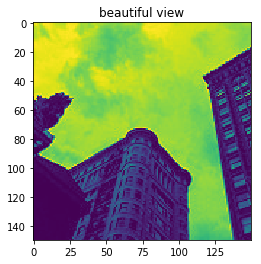

finish to read data from tfrecord file!


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt

tfrecord_path_none = "/content/ML-MC/test.record"

filename_queues = tf.train.string_input_producer([tfrecord_path_none])

# 定义不同压缩选项的TFRecordReader
reader_none = tf.TFRecordReader(options=None)

# 读取不同的tfrecord文件
_,serialized_example_none = reader_none.read(filename_queues)

# 根据key名字得到保存的features字典
features = tf.parse_single_example(serialized_example_none,
features={
          'width':tf.FixedLenFeature([], tf.int64),
          'height':tf.FixedLenFeature([], tf.int64),
          'depth':tf.FixedLenFeature([], tf.int64),
          'image_raw':tf.FixedLenFeature([],tf.string),
          'label':tf.FixedLenFeature([6,1],tf.int64)
})

# 获取参数
depth = tf.cast(features['depth'], tf.int64)
height = tf.cast(features['height'], tf.int64)
width = tf.cast(features['width'], tf.int64)

        # 还原image
image = tf.decode_raw(features['image_raw'], tf.float32)
image = tf.reshape(image, [height,width, depth])
image = image - 0.5
# 启用队列协调管理器，并使用tf.train.start_queue_runners启动队列文件线程


sess = tf.Session()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)
image= sess.run(image)
heigth=sess.run(height)
# 关闭线程以及会话
coord.request_stop()
coord.join(threads)
sess.close()

print(height)
# 显示读取到的图片
plt.imshow(np.squeeze(image))
plt.title("beautiful view")
plt.show()

print("finish to read data from tfrecord file!")

##检测大小不统一的图片

In [0]:
import os
import glob
import tensorflow as tf
import numpy as np
from skimage import io,color



def check(data_path,dest_path):
  os.chdir(data_path)
  folders=os.listdir()
  folders.sort()
  i=0
  with tf.python_io.TFRecordWriter(dest_path) as writer:
    for folder in folders:
      path=data_path+"/"+folder
      img_paths=glob.glob(os.path.join(path,"*.jpg"))
      for img_path in img_paths:
        img=io.imread(img_path)
        img=color.rgb2gray(img)
        if 3 == img.ndim:
          rows, cols, depth = img.shape
        else:
          rows, cols = img.shape
          depth = 1
        if cols!=150:
          print(img_path,img.shape)
        elif rows!=150:
          print(img_path,img.shape)

check("/content/ML-MC/seg_train","/content/ML-MC/train.record")

/content/ML-MC/seg_train/buildings/5358.jpg (124, 150)
/content/ML-MC/seg_train/forest/5483.jpg (136, 150)
/content/ML-MC/seg_train/forest/14315.jpg (133, 150)
/content/ML-MC/seg_train/forest/5643.jpg (108, 150)
/content/ML-MC/seg_train/forest/1004.jpg (113, 150)
/content/ML-MC/seg_train/forest/14609.jpg (115, 150)
/content/ML-MC/seg_train/forest/7174.jpg (113, 150)
/content/ML-MC/seg_train/forest/15776.jpg (135, 150)
/content/ML-MC/seg_train/forest/12108.jpg (108, 150)
/content/ML-MC/seg_train/glacier/18110.jpg (102, 150)
/content/ML-MC/seg_train/glacier/3148.jpg (97, 150)
/content/ML-MC/seg_train/glacier/2837.jpg (76, 150)
/content/ML-MC/seg_train/glacier/1010.jpg (110, 150)
/content/ML-MC/seg_train/glacier/1740.jpg (134, 150)
/content/ML-MC/seg_train/glacier/12983.jpg (120, 150)
/content/ML-MC/seg_train/glacier/17654.jpg (119, 150)
/content/ML-MC/seg_train/glacier/17611.jpg (123, 150)
/content/ML-MC/seg_train/glacier/12634.jpg (111, 150)
/content/ML-MC/seg_train/glacier/17528.jpg (1